# Custom ResNet50 for Object Recognition in Images with AdamW on CIFAR-10

**Dataset's link:** [CIFAR-10 Competition on Kaggle](https://www.kaggle.com/competitions/cifar-10/overview/description)

---

## Description

CIFAR-10 is an established computer-vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of **60,000 32x32 color images** containing one of **10 object classes**, with **6,000 images per class**. 

It was collected by **Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton**.



---

## Data Description

The CIFAR-10 data consists of **60,000 32x32 color images** in 10 classes, with **6,000 images per class**:

- **50,000 training images**
- **10,000 test images**

The official train/test split is preserved. Provided files include:

- `train.7z` — a folder containing training images in PNG format  
- `test.7z` — a folder containing test images in PNG format  
- `trainLabels.csv` — the training labels  

>Note:
>To discourage cheating (e.g., hand labeling), the test set contains:
>- **290,000 junk images** (ignored in scoring)
>- Trivial modifications to official 10,000 test images to prevent hash lookup

You must predict labels for **all 300,000 images**.

---

## Label Classes

The dataset has 10 classes:

- airplane  
- automobile  
- bird  
- cat  
- deer  
- dog  
- frog  
- horse  
- ship  
- truck  

> Note:  
> - “Automobile” includes sedans, SUVs, etc.  
> - “Truck” includes only large trucks (not pickup trucks)  
> - Classes are completely distinct (no overlap)


# Resnet50 architecture


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Data preprocessing

In [3]:
#Data augmentation
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
train_transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),  
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(20),
    v2.RandomCrop(32, padding=4),  
    v2.Normalize(mean=mean,
                 std=std)  
])

dev_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(20),
    v2.RandomCrop(32, padding=4),
    v2.Normalize(mean=mean,
                 std=std)  
])

test_transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),    
    v2.Normalize(mean=mean,
                 std=std)  
])

train_datasets = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
dev_datasets = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=dev_transform)
test_datasets = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=256, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_datasets, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=256, shuffle=True)

100%|██████████| 170M/170M [00:03<00:00, 50.2MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


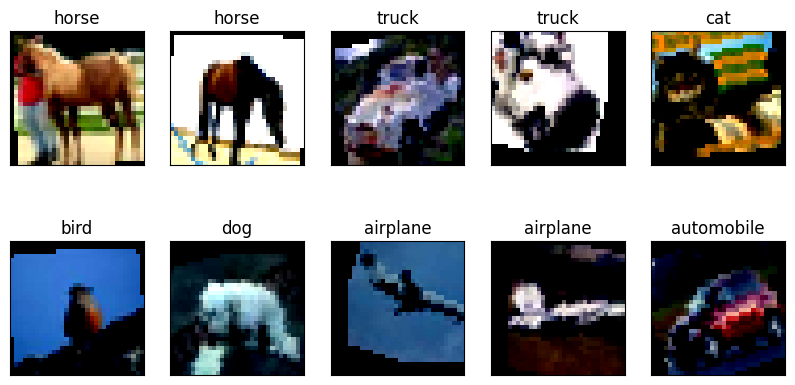

In [4]:
classes = train_datasets.classes

def im_convert(tensor):
    img = tensor.cpu().clone().detach().numpy() 
    img = img.transpose(1, 2, 0)
    img = img * np.array(tuple(mean)) + np.array(tuple(std))
    img = img.clip(0, 1)
    return img

data_iterable = iter(train_loader) 
images, labels = next(data_iterable) 
fig = plt.figure(figsize=(10, 5)) 

for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

# Training model

In [5]:
#Model
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        self.maxpool = nn.Identity()

        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def _make_layer(self, block, num_res_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels * 4)
            )

        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels * 4

        for _ in range(num_res_blocks - 1):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channels=3, num_classes=10):
    return ResNet(Block, [3, 4, 6, 3], img_channels, num_classes)

model = ResNet50().to(device)

# Optimizer & training

In [6]:
#Optimizer
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

train_losses = []
dev_losses = []
train_accuracies = []
dev_accuracies = []

best_accuracy = 0.0
patience = 10
epochs_no_improve = 0
best_model_path = "best_model.pt"

# Training
n_total_steps = len(train_loader)
for epoch in range(epochs):
    running_loss = 0.0
    n_correct_train = 0
    n_samples_train = 0

    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        n_correct_train += (predicted == labels).sum().item()
        n_samples_train += labels.size(0)

    train_acc = 100.0 * n_correct_train / n_samples_train
    train_loss = running_loss / len(train_loader)

    # Evaluate on dev set
    model.eval()
    dev_loss = 0.0
    n_correct = 0
    n_samples = 0

    with torch.no_grad():
        for images, labels in dev_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            dev_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            n_correct += (predicted == labels).sum().item()
            n_samples += labels.size(0)

    dev_acc = 100.0 * n_correct / n_samples
    dev_loss = dev_loss / len(dev_loader)

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"  Train Loss     : {train_loss:.4f}")
    print(f"  Train Accuracy : {train_acc:.2f}%")
    print(f"  Dev Loss       : {dev_loss:.4f}")
    print(f"  Dev Accuracy   : {dev_acc:.2f}%")

    train_losses.append(train_loss)
    dev_losses.append(dev_loss)
    train_accuracies.append(train_acc)
    dev_accuracies.append(dev_acc)

    # Early stopping check
    if dev_acc > best_accuracy:
        best_accuracy = dev_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping")
        break

print("Training done")

Epoch [1/50]
  Train Loss     : 1.7223
  Train Accuracy : 37.22%
  Dev Loss       : 1.6089
  Dev Accuracy   : 44.24%
Epoch [2/50]
  Train Loss     : 1.2403
  Train Accuracy : 55.06%
  Dev Loss       : 1.1779
  Dev Accuracy   : 58.07%
Epoch [3/50]
  Train Loss     : 1.0467
  Train Accuracy : 62.65%
  Dev Loss       : 1.0333
  Dev Accuracy   : 63.28%
Epoch [4/50]
  Train Loss     : 0.9007
  Train Accuracy : 68.08%
  Dev Loss       : 1.0775
  Dev Accuracy   : 63.17%
Epoch [5/50]
  Train Loss     : 0.8039
  Train Accuracy : 71.63%
  Dev Loss       : 0.8561
  Dev Accuracy   : 70.17%
Epoch [6/50]
  Train Loss     : 0.7209
  Train Accuracy : 74.53%
  Dev Loss       : 0.8392
  Dev Accuracy   : 70.44%
Epoch [7/50]
  Train Loss     : 0.6520
  Train Accuracy : 77.05%
  Dev Loss       : 0.7889
  Dev Accuracy   : 73.23%
Epoch [8/50]
  Train Loss     : 0.6008
  Train Accuracy : 78.89%
  Dev Loss       : 0.7704
  Dev Accuracy   : 74.03%
Epoch [9/50]
  Train Loss     : 0.5506
  Train Accuracy : 80.69%

# Result

In [7]:
#Testing
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for _ in range(10)]
    n_class_samples = [0 for _ in range(10)]

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        output = model(images)
        _, predicted = torch.max(output, 1)

        n_samples += labels.size(0)
        n_correct += (predicted==labels).sum().item()

        for i in range(labels.size(0)):
            label = labels[i]
            pred = predicted[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc:.2f}%')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc:.2f}%')

Accuracy of the network: 90.89%
Accuracy of airplane: 91.50%
Accuracy of automobile: 97.30%
Accuracy of bird: 88.70%
Accuracy of cat: 83.90%
Accuracy of deer: 92.90%
Accuracy of dog: 82.30%
Accuracy of frog: 93.70%
Accuracy of horse: 89.50%
Accuracy of ship: 95.20%
Accuracy of truck: 93.90%


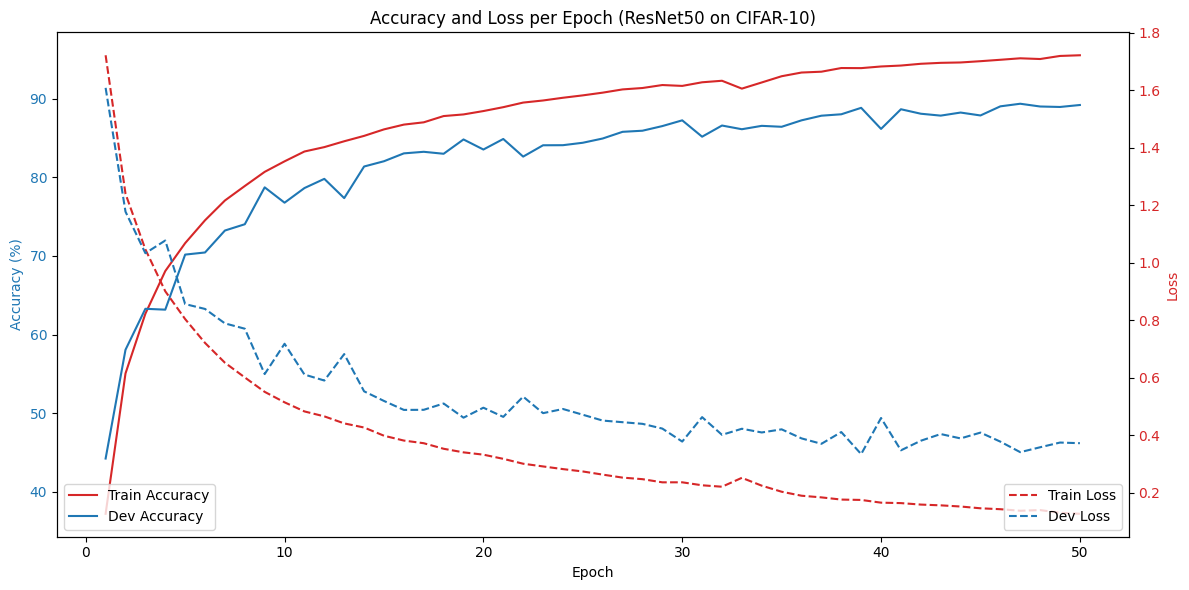

In [8]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color_acc = "tab:blue"
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy (%)", color=color_acc)
ax1.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy", color="tab:red", markersize=3)
ax1.plot(range(1, len(dev_accuracies)+1), dev_accuracies, label="Dev Accuracy", color="tab:blue",  markersize=3)
ax1.tick_params(axis='y', labelcolor=color_acc)
ax1.legend(loc="lower left")

ax2 = ax1.twinx()
color_loss = "tab:red"
ax2.set_ylabel("Loss", color=color_loss)
ax2.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss", color="tab:red", linestyle='--',  markersize=3)
ax2.plot(range(1, len(dev_losses)+1), dev_losses, label="Dev Loss", color="tab:blue", linestyle='--', markersize=3)
ax2.tick_params(axis='y', labelcolor=color_loss)
ax2.legend(loc="lower right")

plt.title("Accuracy and Loss per Epoch (ResNet50 on CIFAR-10)")
plt.tight_layout()
plt.show()